In [2]:
import pandas as pd
from pandas import Series, DataFrame
import datetime 
from datetime import datetime

In [166]:
disney_p = pd.read_csv('/Users/chereowang27/NYCDSA/Python_Intro_Project/data/disney_plus_shows.csv', header=0)
netflix = pd.read_csv('/Users/chereowang27/NYCDSA/Python_Intro_Project/data/netflix_list.csv', header=0)

#convert added at date from str to datetime, make variable for the year, and month-year
disney_p['added_at'] = disney_p["added_at"].apply(lambda s: datetime.strptime(s, "%d-%b-%y"))
disney_p['added_atyear'] = disney_p['added_at'].apply(lambda s: s.strftime('%y'))
disney_p['added_atmonth_year'] = disney_p['added_at'].apply(lambda s: s.strftime('%b-%y'))
disney_p['added_atmonth_year_new'] = pd.to_datetime(disney_p['added_atmonth_year'], format = '%b-%y')

#convert runtime & imdb_rating to numeric
disney_p['runtime'] = disney_p['runtime'].str.split(' ')
disney_p['runtime'] = [pd.to_numeric(val[0:1]) if hasattr(val, '__iter__') else None for val in disney_p["runtime"]]

disney_p['data'] = 'Disney_plus'
netflix['data'] = 'Netflix'
#disney_p['added_atmonth_year'] =  disney_p['added_atyear'].apply(lambda s: datetime.date(s.month, s.year))

hyphen = disney_p['year'].str.split(pat = '-', expand = True ).loc[30,0][4]
df_year = disney_p['year'].str.split(pat = hyphen, expand = True ) \
            .rename(columns = {0:'yearStart', 1: 'yearEnd'})
       

disney_p = pd.concat([disney_p,df_year], axis = 1)

#count the number of movies in each genre
d_movie = disney_p[(disney_p['type']=='movie')&(disney_p['added_atyear'] == '19')]

In [167]:
# this checks where the titles from disney plus and netflix titles overlap
# 19 titles in both networks
disney_nf = pd.merge(disney_p[['imdb_id','imdb_rating','title']],
          netflix[['imdb_id','rating','title']],
                  on='imdb_id', 
                  how = 'inner', 
         suffixes= ('_disney','_nf')
        )
print('disney_nf')
# this checks if imdb_rating in disney plus data is same as rating in netflix data. Not all, but will take use them as same metric
disney_nf['imdb_rating'] == disney_nf['rating']

#compare imdb scores of movies in disney & netflix 
d_movie = d_movie.rename(columns = {'imdb_rating': 'rating'})
nf_movie = netflix[(netflix['type']=='movie')& (netflix['startYear'] < 2020)].rename(columns={'genres':'genre','startYear': 'added_atyear'})
allMovie = pd.concat([d_movie[['imdb_id','rating', 'genre', 'added_atyear','data']],nf_movie[['imdb_id','rating','genre','added_atyear','data']]])
allMovie.reindex()



disney_nf


,imdb_id,rating,genre,added_atyear,data
0,tt0147800,7.3,"Comedy, Drama, Romance",19,Disney_plus
2,tt0115433,5.7,"Adventure, Comedy, Crime, Family",19,Disney_plus
3,tt0324941,5.8,"Animation, Adventure, Comedy, Family, Musical",19,Disney_plus
4,tt0211181,4.9,"Adventure, Comedy, Family",19,Disney_plus
5,tt1846442,6.3,"Comedy, Fantasy, Romance",19,Disney_plus
...,...,...,...,...,...
6168,tt9606614,NaN,Drama,2017.0,Netflix
6176,tt4942048,NaN,Documentary,2006.0,Netflix
6185,tt4590912,NaN,Documentary,2016.0,Netflix
6188,tt0325019,NaN,\N,2002.0,Netflix


In [168]:
allMovie['genre'] = allMovie['genre'].replace(" ", '')
tmp_df = allMovie.loc[~allMovie["genre"].isnull()]
tmp_df
df_all_ratings = pd.DataFrame(sum([
    [(pair[0], gn, pair[2], pair[3]) for gn in pair[1]]
    for pair in zip(tmp_df["imdb_id"], 
                    tmp_df["genre"].str.replace(" ","").str.split(","),
                    tmp_df["rating"], 
                    tmp_df['data'])
], start = []))

In [169]:
df_all_ratings

,0,1,2,3
0,tt0147800,Comedy,7.3,Disney_plus
1,tt0147800,Drama,7.3,Disney_plus
2,tt0147800,Romance,7.3,Disney_plus
3,tt0115433,Adventure,5.7,Disney_plus
4,tt0115433,Comedy,5.7,Disney_plus
...,...,...,...,...
6829,tt9606614,Drama,NaN,Netflix
6830,tt4942048,Documentary,NaN,Netflix
6831,tt4590912,Documentary,NaN,Netflix
6832,tt0325019,\N,NaN,Netflix


In [170]:
df_all_ratings.columns = ['imdb_id','genre','rating','network']
df_all_ratings

,imdb_id,genre,rating,network
0,tt0147800,Comedy,7.3,Disney_plus
1,tt0147800,Drama,7.3,Disney_plus
2,tt0147800,Romance,7.3,Disney_plus
3,tt0115433,Adventure,5.7,Disney_plus
4,tt0115433,Comedy,5.7,Disney_plus
...,...,...,...,...
6829,tt9606614,Drama,NaN,Netflix
6830,tt4942048,Documentary,NaN,Netflix
6831,tt4590912,Documentary,NaN,Netflix
6832,tt0325019,\N,NaN,Netflix


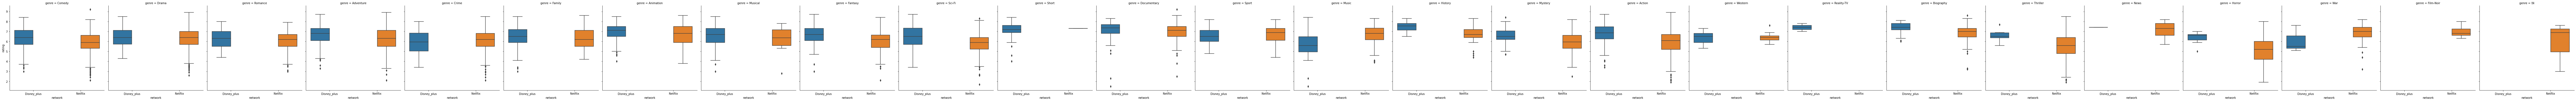

In [171]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.catplot(data = df_all_ratings,
            hue = 'network', 
            x = 'network',
            y = 'rating',
            col = 'genre',
            kind = 'box'
           )
